Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

In [5]:
import os
import copy
import warnings
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from pytrends.request import TrendReq
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [6]:
cwd = os.getcwd()

In [7]:
#list all files in data folder
print(subprocess.check_output(['ls','data/']).decode('UTF-8'))

external_data
raw_data



In [8]:
'''
importing all files, considering onle two files test 
and store since sales data is not available in test station
'''
store = pd.read_csv(cwd+'/data/raw_data/store.csv')
test = pd.read_csv(cwd+'/data/raw_data/test.csv')
train = pd.read_csv(cwd+'/data/raw_data/train.csv')
date_master = pd.read_excel(cwd+'/data/external_data/date_master.xlsx', sheet_name='date_master')
google_trends = pd.read_csv(cwd+'/data/external_data/google_trends.csv')

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [9]:
#creating working copy of the train data
sales = copy.deepcopy(train)

In [10]:
#replacing categories in StateHoliday column 
holmap = {'0':0, 'a':'public holiday', 'b':'easter holiday', 'c':'christmas holiday', 0:0}
sales.StateHoliday = sales.StateHoliday.map(holmap)

In [11]:
#created date_holiday_master with list of holidays
#acquired from https://www.timeanddate.com/holidays/germany/
#merging the train dataset with the date holiday master created with excel
sales.rename(columns={'Date':'date'}, inplace=True)
date_master.rename(columns={'date ':'date'}, inplace=True)
sales['date']=pd.to_datetime(sales['date'])
sales = sales.merge(date_master, how='left', on='date', suffixes={'','_dm'})

In [12]:
#getting only required columns
sales=sales[['Store', 'date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'day',
       'iso_weeknum', 'weekday', 'month', 'seasons', 'quarter',
       'holidays', 'holiday_type', 'regions_observed']]
sales_cp = copy.deepcopy(sales)

In [13]:
#recoding categories in the regions_observed column
sales_cp.regions_observed.unique()

array([nan, 'BW, BY, HE, NRW, RLP, SL', 'B, BB, MVP, SN, ST, TH',
       'Brandenburg', 'BW, BY, ST', 'Saxony', 'BW, BY, NRW, RLP, SL',
       'BB, MVP, SN, ST, TH', 'Bavaria, Saarland', 'Bavaria*',
       'All except BB', 'BW,\xa0BY,\xa0NRW,\xa0RLP,\xa0SL',
       'BB,\xa0MVP,\xa0SN,\xa0ST,\xa0TH',
       'B,\xa0BB,\xa0MVP,\xa0SN,\xa0ST,\xa0TH',
       'BW,\xa0BY,\xa0HE,\xa0NRW,\xa0RLP,\xa0SL', 'All except\xa0BB',
       'BW,\xa0BY,\xa0ST'], dtype=object)

In [14]:
state_map = {'nan':None,
'BW, BY, HE, NRW, RLP, SL':'BW, BY, HE, NW, RP, SL',
'B, BB, MVP, SN, ST, TH':'B, BB, MV, SN, ST, TH',
'Brandenburg':'BB',
'BW, BY, ST':'BW, BY, ST',
'Saxony':'SN',
'BW, BY, NRW, RLP, SL':'BW, BY, NW, RP, SL',
'BB, MVP, SN, ST, TH':'BB, MV, SN, ST, TH',
'Bavaria, Saarland':'BY, SL',
'Bavaria*':'BY',
'All except BB': 'BW, BY, BE, HB, HH, HE, NI, MV, RP, SL, SN, ST, SH, TH, NW',
'BW,\xa0BY,\xa0NRW,\xa0RLP,\xa0SL': 'BW, BY, NW, RP, SL',
'BB,\xa0MVP,\xa0SN,\xa0ST,\xa0TH':'BB, MV, SN, ST, TH',
'B,\xa0BB,\xa0MVP,\xa0SN,\xa0ST,\xa0TH':'B, BB, MV, SN, ST, TH',
'BW,\xa0BY,\xa0HE,\xa0NRW,\xa0RLP,\xa0SL':'BW, BY, HE, NW, RP, SL', 
'All except\xa0BB':'BW, BY, BE, HB, HH, HE, NI, MV, RP, SL, SN, ST, SH, TH, NW',
'BW,\xa0BY,\xa0ST':'BW, BY, ST'}
sales_cp.regions_observed = sales_cp.regions_observed.map(state_map)

In [15]:
#categories in regions_observed after recoding
sales_cp.regions_observed.unique()

array([nan, 'BW, BY, HE, NW, RP, SL', 'B, BB, MV, SN, ST, TH', 'BB',
       'BW, BY, ST', 'SN', 'BW, BY, NW, RP, SL', 'BB, MV, SN, ST, TH',
       'BY, SL', 'BY',
       'BW, BY, BE, HB, HH, HE, NI, MV, RP, SL, SN, ST, SH, TH, NW'],
      dtype=object)

In [16]:
#subsetting data with only stores and regions_observed columns
#sales_cp.loc[sales_cp.StateHoliday!='public holiday', 'regions_observed'] = None
state_hol = sales_cp[sales_cp.StateHoliday=='public holiday']
state_hol_sub = state_hol[['Store','regions_observed']]
hol_agg = state_hol_sub.groupby(['regions_observed'])['Store'].nunique().reset_index()


In [17]:
#un-processed aggregation with overlapping regions
hol_agg

,regions_observed,Store
0,"BB, MV, SN, ST, TH",167
1,"BW, BY, HE, NW, RP, SL",766
2,"BW, BY, NW, RP, SL",579
3,"BW, BY, ST",309
4,"BY, SL",180
5,SN,75


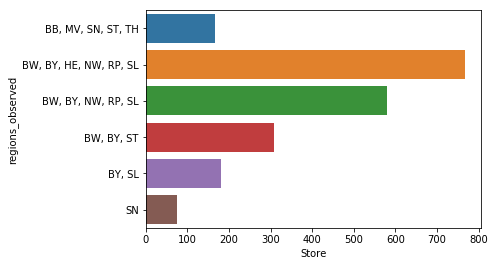

In [18]:
ax = sns.barplot(x=hol_agg.Store, y=hol_agg.regions_observed)

In [19]:
#creating subsets with the region clusters for finding intersect and union of the datasets
reg_1 = state_hol_sub[state_hol_sub.regions_observed=='BW, BY, ST']
reg_2 = state_hol_sub[state_hol_sub.regions_observed=='BY, SL']
reg_3 = state_hol_sub[state_hol_sub.regions_observed=='BW, BY, NW, RP, SL']
reg_4 = state_hol_sub[state_hol_sub.regions_observed=='BW, BY, HE, NW, RP, SL']
reg_5 = state_hol_sub[state_hol_sub.regions_observed=='BB, MV, SN, ST, TH']

In [20]:
SN = state_hol_sub[state_hol_sub.regions_observed=='SN']

In [21]:
BY = pd.DataFrame(np.intersect1d(reg_1.Store, reg_2.Store))
BY = state_hol_sub[state_hol_sub.Store.isin(BY[0])].drop_duplicates()

In [22]:
BW_ST = pd.DataFrame(np.setxor1d(reg_1.Store, BY.Store))
BW_ST = state_hol_sub[state_hol_sub.Store.isin(BW_ST[0])].drop_duplicates()
BW = pd.DataFrame(np.intersect1d(reg_3.Store, BW_ST.Store))
BW = state_hol_sub[state_hol_sub.Store.isin(BW[0])].drop_duplicates()

In [23]:
ST = pd.DataFrame(np.setxor1d(BW.Store, BW_ST.Store))
ST = state_hol_sub[state_hol_sub.Store.isin(ST[0])].drop_duplicates()

In [24]:
SL = pd.DataFrame(np.setxor1d(reg_2.Store, BY.Store))
SL = state_hol_sub[state_hol_sub.Store.isin(SL[0])].drop_duplicates()

In [25]:
#for some reason HE also seems to contain SN, removing from the subset
HE_SN = pd.DataFrame(np.setxor1d(reg_3.Store, reg_4.Store))
HE_SN = state_hol_sub[state_hol_sub.Store.isin(HE_SN[0])].drop_duplicates()
HE = pd.DataFrame(np.setxor1d(HE_SN.Store, SN.Store))
HE = state_hol_sub[state_hol_sub.Store.isin(HE[0])].drop_duplicates()

In [26]:
NW_RP_1 = pd.DataFrame(np.setxor1d(reg_3.Store, BW.Store))
NW_RP_1 = state_hol_sub[state_hol_sub.Store.isin(NW_RP_1[0])].drop_duplicates()
NW_RP_2 = pd.DataFrame(np.setxor1d(NW_RP_1.Store, BY.Store))
NW_RP_2 = state_hol_sub[state_hol_sub.Store.isin(NW_RP_2[0])].drop_duplicates()
NW_RP = pd.DataFrame(np.setxor1d(NW_RP_2.Store, SL.Store))
NW_RP = state_hol_sub[state_hol_sub.Store.isin(NW_RP[0])].drop_duplicates()

In [27]:
BB_MV_TH_1 = pd.DataFrame(np.setxor1d(reg_5.Store, SN.Store))
BB_MV_TH_1 = state_hol_sub[state_hol_sub.Store.isin(BB_MV_TH_1[0])].drop_duplicates()
BB_MV_TH = pd.DataFrame(np.setxor1d(BB_MV_TH_1.Store, ST.Store))
BB_MV_TH = state_hol_sub[state_hol_sub.Store.isin(BB_MV_TH[0])].drop_duplicates()

In [28]:
#finding the stores all over germany except for the ones listed above
ALL = pd.DataFrame(sales_cp['Store'].unique())
ALL_1 = pd.DataFrame(np.setxor1d(ALL[0], reg_4.Store))
ALL_1 = state_hol_sub[state_hol_sub.Store.isin(ALL_1[0])].drop_duplicates()
BE_HB_HH_NI_SH = pd.DataFrame(np.setxor1d(ALL_1.Store, reg_5.Store))
BE_HB_HH_NI_SH = ALL_1[ALL_1.Store.isin(BE_HB_HH_NI_SH[0])].drop_duplicates()

In [29]:
#naming dataframes and looking for common values
SN.name='SN'
ST.name='ST'
BW.name='BW'
BY.name='BY'
HE.name='HE'
SL.name='SL'
NW_RP.name='NW_RP'
BB_MV_TH.name='BB_MV_TH'
BE_HB_HH_NI_SH.name='BE_HB_HH_NI_SH'

In [30]:
city = [SN, ST, BW, BY, HE, SL, NW_RP, BB_MV_TH, BE_HB_HH_NI_SH]
for i in range(len(city)):
    for j in range(len(city)):
        if np.array_equal(city[i].Store, city[j].Store):
            print(city[i].name,city[j].name,np.array_equal(city[i].Store, city[j].Store))

SN SN True
ST ST True
BW BW True
BY BY True
HE HE True
SL SL True
NW_RP NW_RP True
BB_MV_TH BB_MV_TH True
BE_HB_HH_NI_SH BE_HB_HH_NI_SH True


In [31]:
#adding columns in subsets with mapped region
SN['mapped_region'] = "SN"
ST['mapped_region'] = "ST"
BW['mapped_region'] = "BW"
BY['mapped_region'] = "BY"
HE['mapped_region'] = "HE"
SL['mapped_region'] = "SL"
NW_RP['mapped_region'] = "NW_RP"
BB_MV_TH['mapped_region'] = "BB_MV_TH"
BE_HB_HH_NI_SH['mapped_region'] = "BE_HB_HH_NI_SH"

In [32]:
#combining all store-region mapping subsets
frames = [SN, ST, BW, BY, HE, SL, NW_RP, BB_MV_TH, BE_HB_HH_NI_SH]
store_reg = pd.concat(frames).drop_duplicates()

In [33]:
#processed mapping sums to 1115 stores
store_reg.groupby(['mapped_region'])['Store'].nunique().reset_index()

,mapped_region,Store
0,BB_MV_TH,36
1,BE_HB_HH_NI_SH,257
2,BW,73
3,BY,180
4,HE,112
5,NW_RP,326
6,SN,75
7,ST,56


In [87]:
#further identifying regions for above clusters using the school holiday information
#acquired from https://www.tuxx.uk/countries/germany/schoolholidays/2018/
school_hols = pd.read_excel(cwd+'/data/external_data/schol_out_trans.xlsx', sheet_name='transformed_hols')

In [88]:
school_hols.head()

,region,region_code,holiday,key,from,to
0,Baden-WÃ¼rttemberg,BW,autumn,Baden-WÃ¼rttembergBWautumn,2013-10-28,2013-10-30 00:00:00
1,Baden-WÃ¼rttemberg,BW,christmas,Baden-WÃ¼rttembergBWchristmas,2012-12-24,2013-01-05 00:00:00
2,Baden-WÃ¼rttemberg,BW,easter,Baden-WÃ¼rttembergBWeaster,2013-03-25,2013-04-05 00:00:00
3,Baden-WÃ¼rttemberg,BW,pentecost,Baden-WÃ¼rttembergBWpentecost,2013-05-21,2013-06-01 00:00:00
4,Baden-WÃ¼rttemberg,BW,summer,Baden-WÃ¼rttembergBWsummer,2013-07-25,2013-09-07 00:00:00


NW_RP
BB_MV_TH
BE_HB_HH_NI_SH


In [35]:
#getting google trend information
pytrends = TrendReq(hl='en-US',tz='60')
kw_list = ['rossmann']

In [36]:
#unable to collect google trends data at a daily level, downloading manually
#pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='DE', gprop='froogle')
#ross1318 = pytrends.interest_over_time()